In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv


import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from scipy.optimize import minimize_scalar

from poly_basis import *

from ex2_helper import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Parameters

In [2]:
file_name = 'node_sets'

node_sets = ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
#node_sets = ['spiral']
#node_sets = ['sym_t_design']
#node_sets = ['icos']

ns = [400 * 2**i for i in range(0,6)]
#ns = [50, 170, 500]
print(ns)

#rbf_labels = ['r^3', 'r^4*log(r)', 'r^5', 'r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9', 'gaussian']
#rbf_labels = ['r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9']
#rbf_labels = ['r^3', 'r^5', 'r^9', 'gaussian']
#rbf_labels = ['gaussian']
rbf_labels = ['r^9', 'gaussian']
#rbf_labels = ['r^9']

#epsilons = [1, .5, .25, .1, .05]
#epsilons = [1, .05]
#epsilons = [.1, .01, .001]
epsilons = [1]
#epsilons = [4, 2, 1, .5, .25]

#basis_degs = [2] # -1 for no terms
basis_degs = range(2,5) # -1 for no terms
basis_types = ['s'] * len(basis_degs) # p for polynomial and s for spherical harmonics


solution_index = 20

sol_deg = sphere_harm_degs[solution_index]
foo = lambda x: sphere_harm[solution_index](*x)*sol_deg*(sol_deg+1)
exact = lambda x: sphere_harm[solution_index](*x)
print('Harmonic degree: %d' % sphere_harm_degs[solution_index])

#foo, exact = foo3, exact3

#stencil_sizes = [7, 11, 31]
#stencil_sizes = [11, 23, 31]
stencil_sizes = [13]
auto_choose_stencil = True
def choose_stencil_size(deg):
    return max(2*(deg+1)**2, 11)

calculate_weights_cond = False
calculate_stencil_conds = False

optimize_epsilon = True
target_cond = 10**12
optimize_all_stencils = True

notes = ''

[400, 800, 1600, 3200, 6400, 12800]
Harmonic degree: 4


# RBFs

In [3]:
rbf_dict = {}

even_tol = 1e-14

def rbf(r):
    return r**3
def d_phi_dr_div_r(r):
    return 3 * r
rbf_dict['r^3'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**2 * (1 + 4*np.log(r))
rbf_dict['r^4*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**5
def d_phi_dr_div_r(r):
    return 5 * r**3
rbf_dict['r^5'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * (1 + 6*np.log(r))
rbf_dict['r^6*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**7
def d_phi_dr_div_r(r):
    return 7 * r**5
rbf_dict['r^7'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**8 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * (1 + 8*np.log(r))
rbf_dict['r^8*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**9
def d_phi_dr_div_r(r):
    return 9 * r**7
rbf_dict['r^9'] = (rbf, d_phi_dr_div_r)

# RBFs with Shape Parameter
shape_rbfs = []

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)
rbf_dict['gaussian'] = (rbf, d_phi_dr_div_r)
shape_rbfs += ['gaussian']



def grad_rbf(node, node_center):
    r = dist(node, node_center)
    return d_phi_dr_div_r(r) * (np.array(node) - np.array(node_center))

# Loops

In [4]:
columns = ['node_set', 'rbf',  'epsilon', 'basis_deg', 'basis_type', 'N', 'stencil_size', 'max_error', 'rel_L2_error']
data = pd.DataFrame(columns=columns)

assert len(basis_types) == len(basis_degs)
for node_set in node_sets:
    print(node_set + ' nodes')
    for n_try in ns:
        # generate nodes
        if node_set == 'spiral':
            n = n_try
            nodes = gen_spiral_nodes(n)
        elif node_set == 'sym_t_design':
            n, nodes = gen_symmetric_t_design_nodes(n_try)
        elif node_set == 'min_energy':
            n, nodes = gen_min_energy_nodes(n_try)
        elif node_set == 'max_det':
            n, nodes = gen_max_det_nodes(n_try)
        elif node_set == 'icos':
            n, nodes = gen_equ_area_icos_nodes(n_try)
        
        projectors = [np.eye(3) - np.outer(node, node) for node in nodes]
        avg_val = np.sum([exact(node) for node in nodes])
        print('n: %d' % n)

        # generate stencils
        tree = cKDTree(np.array(nodes))
        

        # generate weights
        for rbf_label in rbf_labels:
            print('\trbf: ' + rbf_label)
            rbf, d_phi_dr_div_r = rbf_dict[rbf_label]
            skip_no_epsilon = False
            if optimize_epsilon:
                epsilons = [1]
            for epsilon in epsilons:
                if skip_no_epsilon:
                    continue
                if rbf_label not in shape_rbfs:
                    #epsilon = ''
                    skip_no_epsilon = True
                else:
                    print('\t\tepsilon %f' % epsilon)
                
                for stencil_size in stencil_sizes:
                    if auto_choose_stencil:
                        if stencil_size != stencil_sizes[0]:
                            continue
                            # skip if doing more than one stencil size
                    if stencil_size > n:
                        stencil_size = n
                    
                    stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                    print('\t\t\tstencil size: %d' % stencil_size)
                    
                    for basis_deg, basis_type in zip(basis_degs, basis_types):
                        if calculate_stencil_conds:
                            largest_stencil_cond = 0
                        else:
                            largest_stencil_cond = '-'
                            skeel = '-'
                        if auto_choose_stencil:
                            stencil_size = choose_stencil_size(basis_deg)
                            stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                            
                        if stencil_size > n:
                            stencil_size = n
                            
                        if auto_choose_stencil:
                            print('\t\t\tstencil size changed: %d' % stencil_size)
                        
                        weights = np.zeros((n, stencil_size))
                        row_index = [r for r in range(n) for c in range(stencil_size)]
                        col_index = np.zeros((n, stencil_size))
                        for i, stencil in enumerate(stencils):

                            col_index[i] = stencil
                            nn = np.array([nodes[i] for i in stencil])
                            nn_proj = [projectors[i] for i in stencil]
                            center_x, center_y, center_z = nn[0]
                            
                            if basis_type == 'p':
                                P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)
                            elif basis_type == 's':
                                P, rhs_x, rhs_y, rhs_z = gen_sphere_harm_basis(basis_deg, nn, nn_proj)
                            
                            if optimize_epsilon and (i==0 or optimize_all_stencils) and not skip_no_epsilon:
                                # optimize cond for first stencil
                                dist_mat = np.array([[dist(node, node_center) for node in nn] for node_center in nn])
                                optimization_result = minimize_scalar(root_find, args=(dist_mat, P, target_cond))
                                epsilon = optimization_result['x']
                                if i==0:
                                    print(print('\t\tepsilon %f' % epsilon))

                            A = np.array([[rbf(dist(node, node_center)) for node in nn] for node_center in nn])
                            #P = np.array([[1, x-center_x, y-center_y, z-center_z] for x,y,z in nn])
                            #P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)

                            num_basis = P.shape[1]

                            AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
                            
                            if calculate_stencil_conds:
                                my_cond = cond(AP)
                                if i==0:
                                    skeel = skeel_cond(AP)
                                if my_cond > largest_stencil_cond:
                                    largest_stencil_cond = my_cond

                            rhsAs = np.array([ [ nn_proj[j]@grad_rbf(node, node_center) for j, node in enumerate(nn) ]
                                                for node_center in nn] )
                            
                            singular_stencil = False
                            try:
                                rhsA = rhsAs[:,:,0] # only the x coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_x]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] = (weights_grad@weights_grad)[0]

                                rhsA = rhsAs[:,:,1] # only the y coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_y]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] += (weights_grad@weights_grad)[0]

                                rhsA = rhsAs[:,:,2] # only the z coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_z]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] += (weights_grad@weights_grad)[0]
                            except la.LinAlgError:
                                print('Singular stencil, skipping case.')
                                singular_stencil = True
                                break

                        if singular_stencil:
                            continue
                        C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

                        # solve steady-state
                        C = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                                        np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')
                        rhs = [-foo(node) for node in nodes] + [avg_val]
                        if calculate_weights_cond:
                            weights_cond = cond(C.todense())
                        else:
                            weights_cond = '-'
                        u = spsolve(C, rhs)
                        u = u[:-1]
                        u_true = np.array([exact(node) for node in nodes])
                        data = data.append( 
                            {'node_set': node_set, 'rbf':rbf_label, 'epsilon': epsilon,
                             'basis_deg':np.int(basis_deg), 'basis_type' : basis_type,
                             'N':n, 'stencil_size':stencil_size,
                             'max_error':np.max( np.abs(u-u_true ) ), 
                             'rel_L2_error':la.norm(u-u_true)/la.norm(u_true),
                             'stencil_cond': largest_stencil_cond, 
                             'skeel_cond' : skeel,
                             'weights_cond': weights_cond,
                             'target_cond' : target_cond}, ignore_index=True)


spiral nodes
n: 400
	rbf: r^9
			stencil size: 13
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
	rbf: gaussian
		epsilon 1.000000
			stencil size: 13
			stencil size changed: 18
		epsilon 0.331322
None
			stencil size changed: 32
		epsilon 0.624865
None
			stencil size changed: 50
		epsilon 0.887143
None
n: 800
	rbf: r^9
			stencil size: 13
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
	rbf: gaussian
		epsilon 1.000000
			stencil size: 13
			stencil size changed: 18
		epsilon 0.492098
None
			stencil size changed: 32
		epsilon 0.958446
None
			stencil size changed: 50
		epsilon 1.321206
None
n: 1600
	rbf: r^9
			stencil size: 13
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
	rbf: gaussian
		epsilon 1.000000
			stencil size: 13
			stencil size changed: 18
		epsilon 0.711748
None
			stencil size changed: 32
		epsilon 1.420207
None
			stencil size changed: 50
		epsilon 1.93053

			stencil size changed: 50
		epsilon 5.629028
None
Singular stencil, skipping case.
icos nodes
n: 162
	rbf: r^9
			stencil size: 13
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
	rbf: gaussian
		epsilon 1.000000
			stencil size: 13
			stencil size changed: 18
		epsilon -0.195502
None
			stencil size changed: 32
		epsilon 0.349540
None
			stencil size changed: 50
		epsilon 0.527326
None
n: 642
	rbf: r^9
			stencil size: 13
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
	rbf: gaussian
		epsilon 1.000000
			stencil size: 13
			stencil size changed: 18
		epsilon 0.466527
None
			stencil size changed: 32
		epsilon 0.850745
None
			stencil size changed: 50
		epsilon 1.293105
None
n: 642
	rbf: r^9
			stencil size: 13
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
	rbf: gaussian
		epsilon 1.000000
			stencil size: 13
			stencil size changed: 18
		epsilon 0.466527
None
			stencil siz

In [5]:
display(data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,r^9,1,2,s,400,18,4.512917,0.706701,-,-,1.000000e+12,-
1,spiral,r^9,1,3,s,400,32,0.002662,0.000540,-,-,1.000000e+12,-
2,spiral,r^9,1,4,s,400,50,0.004678,0.000775,-,-,1.000000e+12,-
3,spiral,gaussian,0.331322,2,s,400,18,0.078447,0.011520,-,-,1.000000e+12,-
4,spiral,gaussian,0.624864,3,s,400,32,0.002337,0.000548,-,-,1.000000e+12,-
5,spiral,gaussian,0.887143,4,s,400,50,0.001828,0.000290,-,-,1.000000e+12,-
6,spiral,r^9,1,2,s,800,18,0.996335,0.110148,-,-,1.000000e+12,-
7,spiral,r^9,1,3,s,800,32,0.003122,0.000586,-,-,1.000000e+12,-
8,spiral,r^9,1,4,s,800,50,0.001353,0.000263,-,-,1.000000e+12,-
9,spiral,gaussian,0.492096,2,s,800,18,0.015620,0.001862,-,-,1.000000e+12,-


# Write to File

In [6]:
i = 0
file_name_num = file_name + '_' + str(i) + '.pickle'
while os.path.isfile(os.path.join('pickles',file_name_num)):
    i += 1
    file_name_num = file_name + '_' + str(i) + '.pickle'

f = open(os.path.join('pickles',file_name_num), 'wb')
pickle.dump(data, f)
f.close()
print(file_name_num)

node_sets_1.pickle


In [7]:
read_data = data

# Read from File

In [78]:
file_to_read = 'PHS_better_than_gaussian_0.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
basis_degs = read_data.basis_deg.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
epsilons = read_data.epsilon.unique()
#basis_degs = read_data.basis_deg.unique()

#read_data['sqrtN'] = np.sqrt(read_data['N'])

In [89]:
display(read_data[:10])

,N,basis_deg,basis_type,epsilon,label,max_error,node_set,rbf,rel_L2_error,skeel_cond,stencil_cond,stencil_size,target_cond,weights_cond
0,200,4,s,-0.40749441,NaN,0.00054579,spiral,gaussian,0.00009334,-,-,50,1.00000000e+14,-
1,400,4,s,0.64897182,NaN,0.00056188,spiral,gaussian,0.00007991,-,-,50,1.00000000e+14,-
2,800,4,s,0.98752031,NaN,0.00041646,spiral,gaussian,0.00008392,-,-,50,1.00000000e+14,-
3,1600,4,s,1.4679868,NaN,0.00122257,spiral,gaussian,0.00010512,-,-,50,1.00000000e+14,-
4,3200,4,s,2.1299937,NaN,0.00261987,spiral,gaussian,0.00028737,-,-,50,1.00000000e+14,-
0,12800,4,s,1,r^3 1,0.00004221,spiral,r^3,0.00000813,-,-,50,1.00000000e+14,-
1,12800,4,s,1,r^5 1,0.00003475,spiral,r^5,0.00000674,-,-,50,1.00000000e+14,-
2,12800,4,s,1,r^9 1,0.00000463,spiral,r^9,0.00000092,-,-,50,1.00000000e+14,-
3,25600,4,s,1,r^3 1,0.00000412,spiral,r^3,0.00000059,-,-,50,1.00000000e+14,-
4,25600,4,s,1,r^5 1,0.00000218,spiral,r^5,0.00000029,-,-,50,1.00000000e+14,-


In [92]:
read_data.rbf.unique()

array(['gaussian', 'r^3', 'r^5', 'r^9'], dtype=object)

# Plots

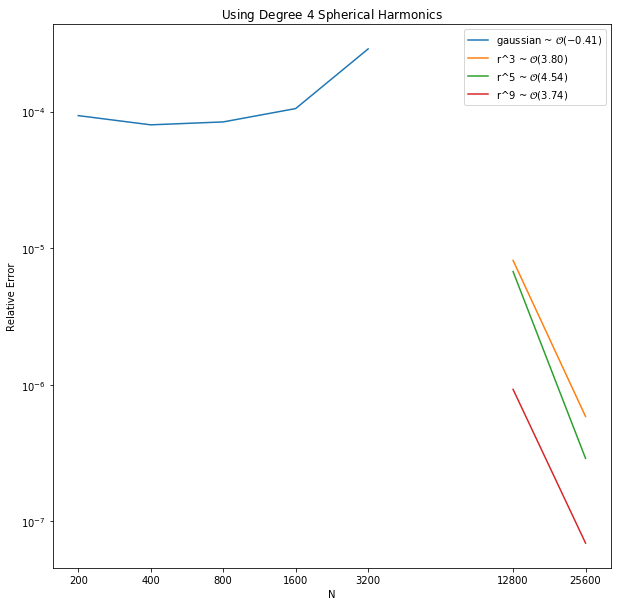

In [100]:
fig, ax_s = plt.subplots(1, sharex=True, figsize=(10,10))

legend = []
for rbf in read_data.rbf.unique():
    plot_data = read_data[read_data.rbf==rbf]
    ax_s.loglog( 'N', 'rel_L2_error', data=plot_data)
    #ax_s[i].set_title('RBF $=' + rbf + '$')
    order_denom = np.log(plot_data.iloc[-1].N/plot_data.iloc[0].N)
    order_num = np.log(plot_data.iloc[-1].rel_L2_error/plot_data.iloc[0].rel_L2_error)
    legend += [rbf + ' ~ $\mathcal{O}(%.2f)$' %(-order_num/order_denom)]
ax_s.legend( legend )

    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(read_data.N.unique(),read_data.N.unique())
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.title('Using Degree $4$ Spherical Harmonics')
plt.show()

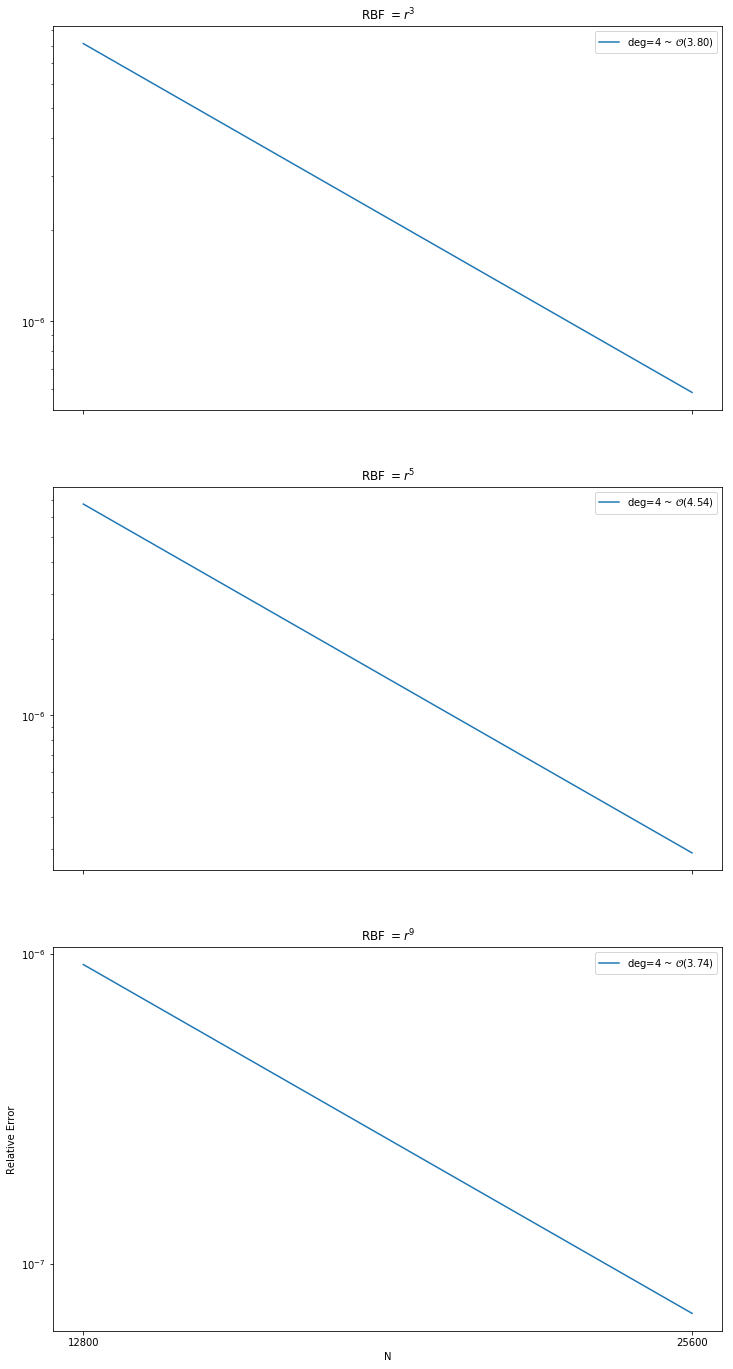

In [67]:
fig, ax_s = plt.subplots(len(rbf_labels), sharex=True, figsize=(12,24))

for i, rbf in enumerate(rbf_labels):
    read_data_slice = read_data[read_data.rbf==rbf]
    legend = []
    for basis_deg in basis_degs:
        plot_data = read_data_slice[read_data_slice.basis_deg==basis_deg]
        ax_s[i].loglog( 'N', 'rel_L2_error', data=plot_data)
        ax_s[i].set_title('RBF $=' + rbf + '$')
        order_denom = np.log(plot_data.iloc[-1].N/plot_data.iloc[0].N)
        order_num = np.log(plot_data.iloc[-1].rel_L2_error/plot_data.iloc[0].rel_L2_error)
        legend += ['deg='+str(basis_deg) + ' ~ $\mathcal{O}(%.2f)$' %(-order_num/order_denom)]
    ax_s[i].legend( legend )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
plt.show()

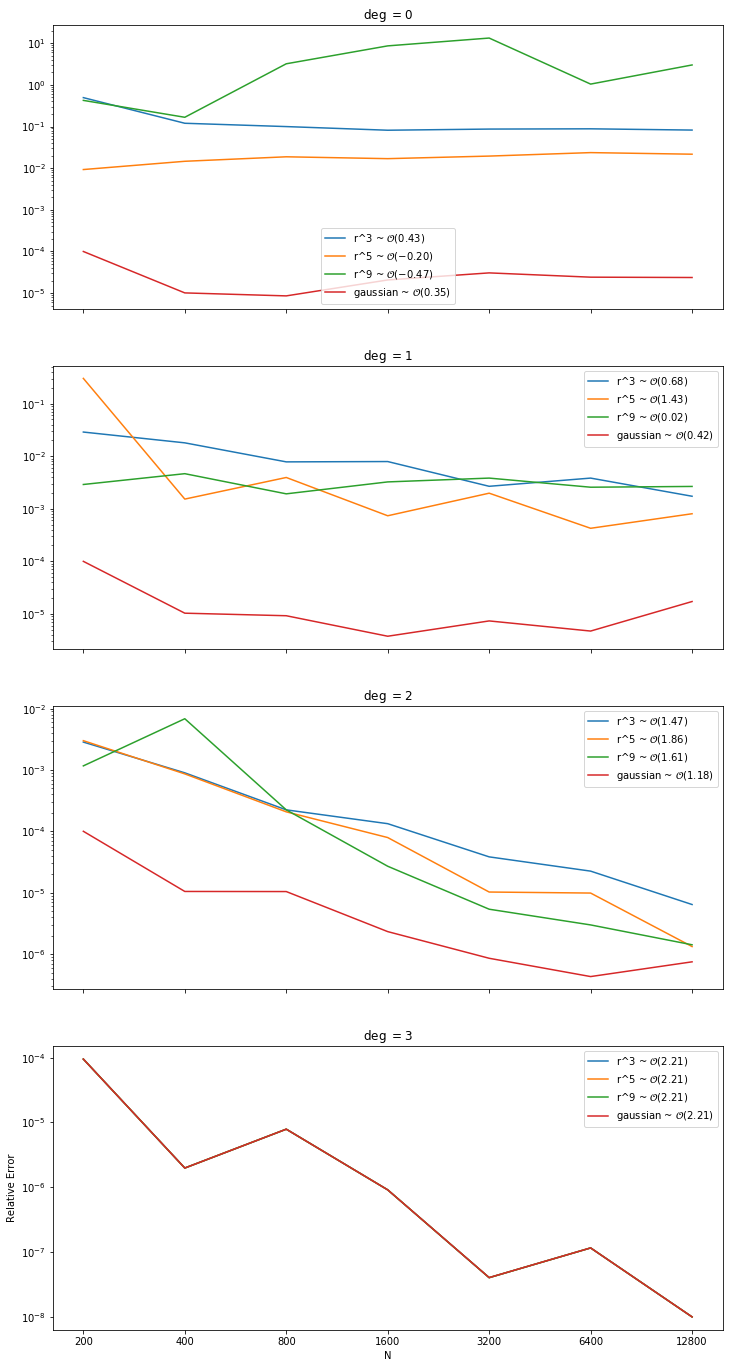

In [58]:
fig, ax_s = plt.subplots(len(basis_degs), sharex=True, figsize=(12,24))

for i, basis_deg in enumerate(basis_degs):
    legend = []
    read_data_slice = read_data[read_data.basis_deg==basis_deg]
    for rbf in rbf_labels:
        plot_data = read_data_slice[read_data_slice.rbf==rbf]
        ax_s[i].loglog( 'N', 'rel_L2_error', data=plot_data)
        ax_s[i].set_title('deg $=' + str(basis_deg) + '$')
        order_denom = np.log(plot_data.iloc[-1].N/plot_data.iloc[0].N)
        order_num = np.log(plot_data.iloc[-1].rel_L2_error/plot_data.iloc[0].rel_L2_error)
        legend += [rbf + ' ~ $\mathcal{O}(%.2f)$' %(-order_num/order_denom)]
    ax_s[i].legend( legend )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
plt.show()

In [61]:
np.log(plot_data.iloc[-1].rel_L2_error / plot_data.iloc[0].rel_L2_error)

-9.171872241407506

In [59]:
order_num

-9.171872241407506

In [62]:
order_denom

4.1588830833596715

In [27]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond,label
0,spiral,r^3,1,0,s,200,31,0.500051,0.493573,678.758658,7.787012e+03,1.000000e+14,66.514532,r^3 1
1,spiral,r^3,1,1,s,200,31,0.033155,0.028796,655.484808,7.621692e+03,1.000000e+14,64.473415,r^3 1
2,spiral,r^3,1,2,s,200,31,0.003710,0.002850,639.936886,7.651137e+03,1.000000e+14,33.784299,r^3 1
3,spiral,r^3,1,3,s,200,31,0.000049,0.000095,1702.330395,1.403435e+05,1.000000e+14,2537.789443,r^3 1
4,spiral,r^5,1,0,s,200,31,0.009532,0.009258,5246.872018,8.923462e+04,1.000000e+14,42.407831,r^5 1
5,spiral,r^5,1,1,s,200,31,0.717953,0.302289,4836.136055,1.779663e+05,1.000000e+14,2298.036983,r^5 1
6,spiral,r^5,1,2,s,200,31,0.003166,0.003005,5205.706285,8.782019e+04,1.000000e+14,45.542807,r^5 1
7,spiral,r^5,1,3,s,200,31,0.000049,0.000095,4762.481802,8.049276e+04,1.000000e+14,112.410421,r^5 1
8,spiral,r^9,1,0,s,200,31,0.533456,0.423741,13827.217413,6.144768e+06,1.000000e+14,7765.512550,r^9 1
9,spiral,r^9,1,1,s,200,31,0.004061,0.002894,15020.557075,9.705750e+05,1.000000e+14,53.617790,r^9 1


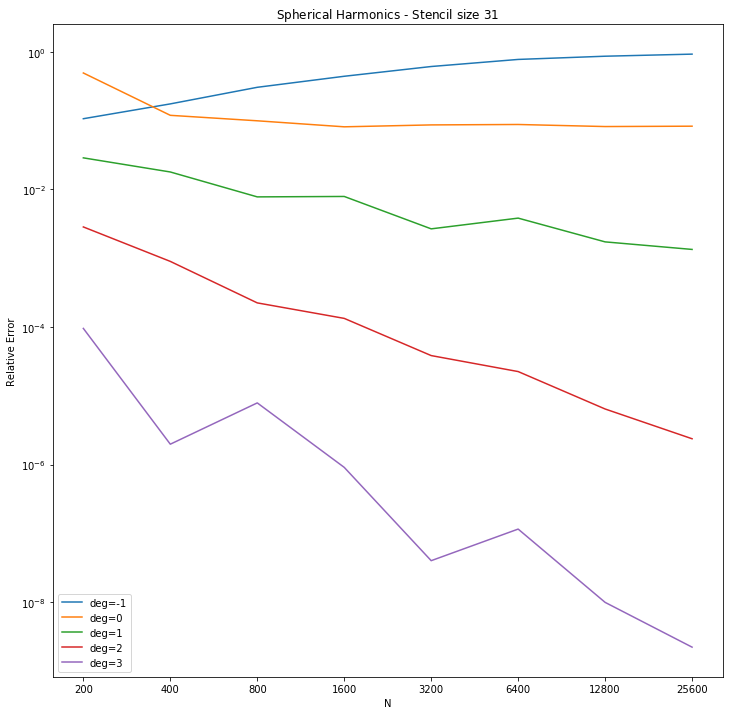

In [39]:
fig, ax_s = plt.subplots(1, sharex=True, figsize=(12,12))

#for i, k in enumerate(basis_degs):
#    legends = []
#    read_data_stencil = read_data[read_data.basis_deg==k]    
for basis_deg in basis_degs[:-1]:
    ax_s.loglog( 'N', 'rel_L2_error', data=read_data[read_data.basis_deg==basis_deg])
    #ax_s.set_title('Basis Degree Size $=' + str(k) + '$')
ax_s.legend( ['deg='+str(basis_deg) for basis_deg in basis_degs] )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.title('Spherical Harmonics - Stencil size $31$')
plt.show()

######################################################
#
# Stencil size = 31
#
######################################################

In [41]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,target_cond,weights_cond,label
0,spiral,r^3,1,-1,s,200,101,0.002075,0.002003,-,1.000000e+14,-,r^3 1
1,spiral,r^3,1,0,s,200,101,0.002130,0.002057,-,1.000000e+14,-,r^3 1
2,spiral,r^3,1,1,s,200,101,0.001953,0.001884,-,1.000000e+14,-,r^3 1
3,spiral,r^3,1,2,s,200,101,0.000569,0.000544,-,1.000000e+14,-,r^3 1
4,spiral,r^3,1,3,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
5,spiral,r^3,1,4,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
6,spiral,r^3,1,5,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
7,spiral,r^3,1,6,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
8,spiral,r^3,1,7,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
9,spiral,r^3,1,-1,s,400,101,0.001046,0.000817,-,1.000000e+14,-,r^3 1


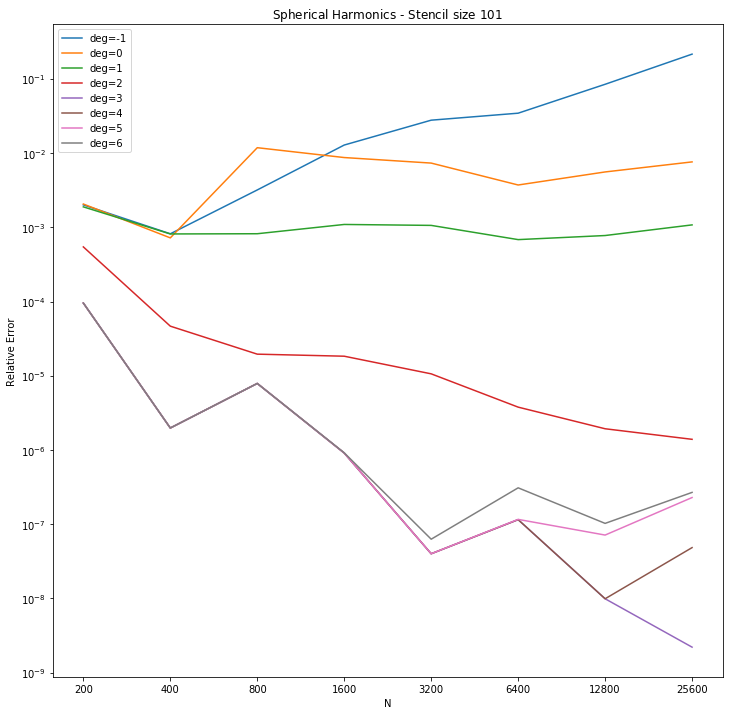

In [42]:
fig, ax_s = plt.subplots(1, sharex=True, figsize=(12,12))

#for i, k in enumerate(basis_degs):
#    legends = []
#    read_data_stencil = read_data[read_data.basis_deg==k]    
for basis_deg in basis_degs[:-1]:
    ax_s.loglog( 'N', 'rel_L2_error', data=read_data[read_data.basis_deg==basis_deg])
    #ax_s.set_title('Basis Degree Size $=' + str(k) + '$')
ax_s.legend( ['deg='+str(basis_deg) for basis_deg in basis_degs] )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.title('Spherical Harmonics - Stencil size $101$')
plt.show()

######################################################
#
# Stencil size = 101
#
######################################################

In [ ]:
fig, ax_s = plt.subplots(2, sharex=True, figsize=(12,12))
ax_s[0].loglog('N', 'max_error', data=read_data[read_data.stencil_size==31])
ax_s[0].set_title('Max error')
ax_s[1].loglog('N', 'rel_L2_error', data=read_data[read_data.stencil_size==31])
ax_s[1].set_title('Relative $L_2$ error')
plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
#plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
#plt.ylabel('Relative Error')

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.epsilon==1)]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

# shape_search_2 - target cond 10^14

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].plot( 'N', 'epsilon', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Shape Parameter')
plt.show()

# shape_search_2 - target cond 10^14

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Stencil Condition Number')
plt.show()

# shape_search_2 - target cond 10^14

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

# shape_search_1 - target cond 10^12

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].plot( 'N', 'epsilon', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Shape Parameter')
plt.show()

# shape_search_1 - target cond 10^12

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Stencil Condition Number')
plt.show()

# shape_search_1 - target cond 10^12

In [141]:
display(read_data[-10:])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,target_cond,weights_cond
2,spiral,gaussian,0.076463,0,p,400,11,0.003763,0.003277,1.000022e+12,1.000000e+12,-
3,spiral,gaussian,0.616967,0,p,400,31,0.000033,0.000025,1.000021e+12,1.000000e+12,-
4,spiral,gaussian,0.132301,0,p,800,11,0.002034,0.002088,1.000025e+12,1.000000e+12,-
5,spiral,gaussian,0.934870,0,p,800,31,0.000066,0.000061,1.000016e+12,1.000000e+12,-
6,spiral,gaussian,0.253591,0,p,1600,11,0.001471,0.001399,1.000051e+12,1.000000e+12,-
7,spiral,gaussian,1.390357,0,p,1600,31,0.000150,0.000142,1.000017e+12,1.000000e+12,-
8,spiral,gaussian,0.451956,0,p,3200,11,0.000484,0.000539,1.000146e+12,1.000000e+12,-
9,spiral,gaussian,2.037936,0,p,3200,31,0.000168,0.000152,1.000147e+12,1.000000e+12,-
10,spiral,gaussian,0.733747,0,p,6400,11,0.000360,0.000341,1.000116e+12,1.000000e+12,-
11,spiral,gaussian,2.946618,0,p,6400,31,0.000112,0.000118,4.026584e+16,1.000000e+12,-


# For Meeting

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')

#plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('rel_L2_error')

#plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('stencil_cond')

#plt.show()

In [ ]:
display(read_data)

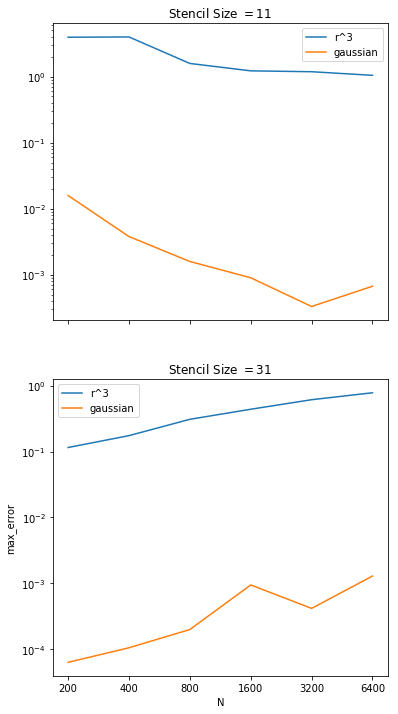

In [61]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==-1]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Not Augmented
#     meeting_0.pickle
#
########################################################################################

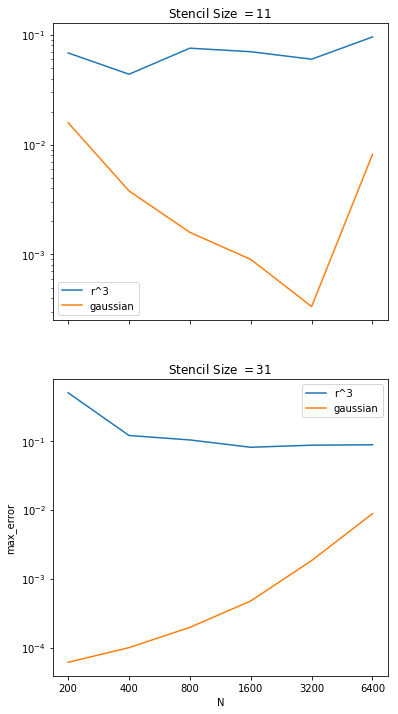

In [62]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==0]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Agumented with constant
#     meeting_0.pickle
#
########################################################################################

In [ ]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==1]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Augmented with linear terms
#     meeting_0.pickle
#
########################################################################################

In [17]:
file_to_read = 'cond_numbers_0.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
epsilons = read_data.epsilon.unique()

display(read_data)

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,weights_cond,label
0,spiral,r^3,0.2,1,p,200,7,0.050125,22.559223,4.992054e+02,42.897164,r^3 0.2
1,spiral,gaussian,0.2,1,p,200,7,0.041990,9.203220,1.504166e+08,56.653412,gaussian 0.2
2,spiral,r^3,0.2,1,p,400,7,0.026098,4.307138,1.341322e+03,86.338668,r^3 0.2
3,spiral,gaussian,0.2,1,p,400,7,0.016095,2.013794,1.180640e+09,105.259963,gaussian 0.2
4,spiral,r^3,0.2,1,p,800,7,0.036502,20.743179,3.726019e+03,173.927786,r^3 0.2
5,spiral,gaussian,0.2,1,p,800,7,0.015350,1.834184,9.392575e+09,221.679517,gaussian 0.2
6,spiral,r^3,0.2,1,p,1600,7,0.039006,21.101553,1.047230e+04,359.237964,r^3 0.2
7,spiral,gaussian,0.2,1,p,1600,7,0.006518,0.829760,7.661370e+10,468.887098,gaussian 0.2
8,spiral,r^3,0.2,1,p,3200,7,0.052004,87.619923,2.955462e+04,721.847822,r^3 0.2
9,spiral,gaussian,0.2,1,p,3200,7,0.001273,2.069589,6.175983e+11,921.067813,gaussian 0.2


Text(0,0.5,'max_error')

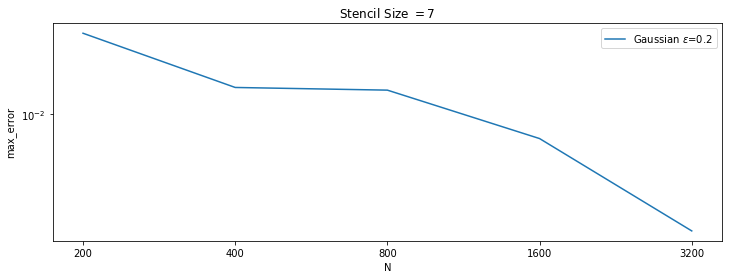

In [18]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,4))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s.loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s.set_title('Stencil Size $=' + str(k) + '$')
    ax_s.legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('max_error')

#plt.show()


Text(0,0.5,'rel_L2_error')

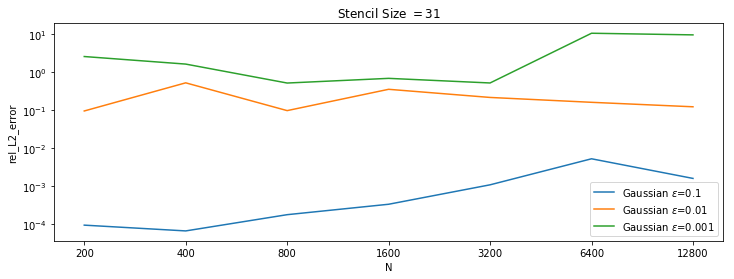

In [23]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,4))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s.loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s.set_title('Stencil Size $=' + str(k) + '$')
    ax_s.legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('rel_L2_error')

#plt.show()

## Nodesets by RBF

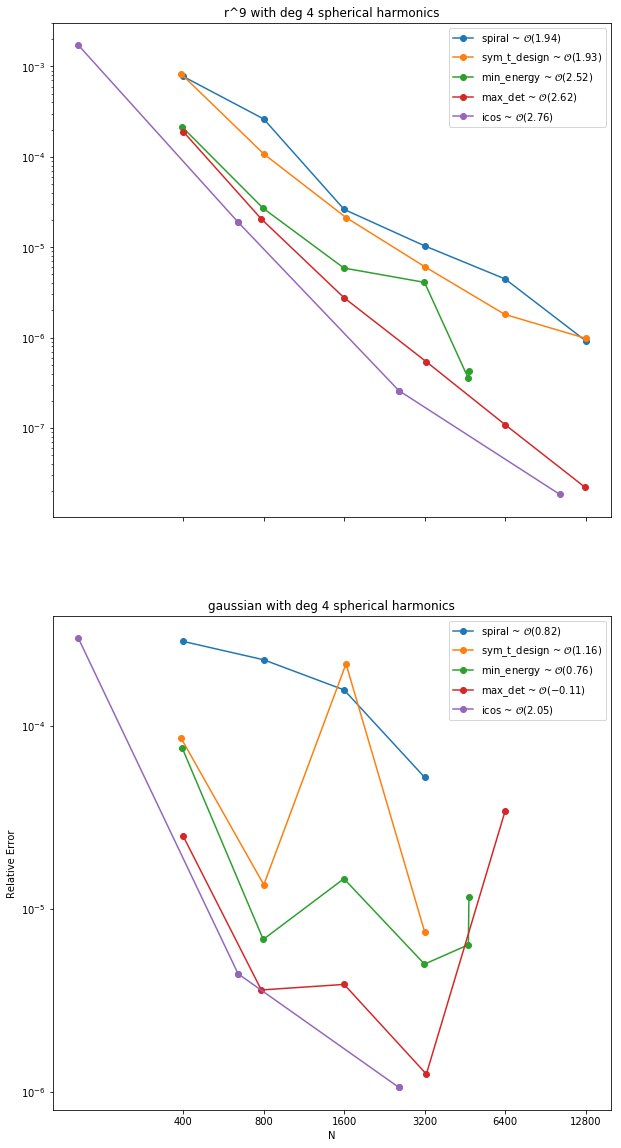

In [21]:
this_deg = 4

all_data = read_data[read_data.basis_deg==this_deg]

fig, ax_s = plt.subplots(len(all_data.rbf.unique()), sharex=True, figsize=(10,20))

for i, rbf in enumerate(all_data.rbf.unique()):
    legend = []
    read_data_slice = all_data[all_data.rbf==rbf]
    for node_set in read_data.node_set.unique():
        plot_data = read_data_slice[read_data_slice.node_set==node_set]
        ax_s[i].loglog( 'N', 'rel_L2_error', data=plot_data, marker='o', linestyle='solid')
        ax_s[i].set_title(rbf + ' with deg ' + str(this_deg) + ' spherical harmonics')
        order_denom = np.log(plot_data.iloc[-1].N/plot_data.iloc[0].N)
        order_num = np.log(plot_data.iloc[-1].rel_L2_error/plot_data.iloc[0].rel_L2_error)
        legend += [node_set + ' ~ $\mathcal{O}(%.2f)$' %(-order_num/order_denom)]
    ax_s[i].legend( legend )
    
plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
plt.show()